<a href="https://colab.research.google.com/github/Vishal-Upendran/IUCAASummerSchool2021/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimate actual redshifts from photometric data

We have photometric data -- magnitudes and colors. We will use this to estimate the actual redshift of the object as measured through its spectrum.

## Step wise procedure

1. Data preparation and processing
2. Pre-preparation: Have summary metrics ready.
3. Linear: Regression using Ordinary least squares
4. Non-linear: Let's do a Neural network in pytorch

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Step 1: Download data

In [4]:
!pip install gdown

Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.13.0-py3-none-any.whl size=9034 sha256=d4e90e04afc6727a2d83ffc00c73e118feb5b894eda31cf48498755893ac370f
  Stored in directory: /home/uvishal/.cache/pip/wheels/6a/87/bd/09b16161b149fd6711ac76b5420d78ed58bd6a320e892117c3
Successfully built gdown


In [5]:
!gdown --id 1D7OZ_ibIjl-2clagDXHBgiX_-BxAycmK 

Downloading...
From: https://drive.google.com/uc?id=1D7OZ_ibIjl-2clagDXHBgiX_-BxAycmK
To: /home/uvishal/Desktop/SummerSchool2021/Skyserver_12_15_2020 3 45 07 AM.csv
82.5MB [00:06, 13.6MB/s]


In [6]:
!pip install scikit-learn --upgrade

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 22.2 MB 3.6 MB/s eta 0:00:01     |███████████████████▏            | 13.3 MB 2.6 MB/s eta 0:00:04
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3


In [2]:
Data = pd.read_csv("Skyserver_12_15_2020 3 45 07 AM.csv",comment="#")

In [3]:
Data.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237678877245244171,318.951692,9.315146,19.51665,18.50036,17.95667,17.53139,17.32035,7777,301,5,53,819657923239110656,GALAXY,0.114299,728,52520,10
1,1237668332026986542,217.940001,14.608378,19.13548,18.55482,17.95603,17.68272,17.63717,5322,301,3,56,6154252554903769088,QSO,1.802680,5466,56033,304
2,1237664092899115053,129.948221,25.213328,19.54955,18.19434,17.83220,17.51329,17.47054,4335,301,3,130,2173034979993348096,GALAXY,0.070813,1930,53347,175
3,1237654604252119048,160.357788,3.567886,17.72343,16.65830,16.23667,16.07098,16.02797,2126,301,1,275,649647859372681216,STAR,0.000570,577,52367,13
4,1237661360769400880,226.001700,38.619699,16.60500,15.66234,15.39406,15.29443,15.29302,3699,301,2,227,5817649714997514240,STAR,-0.000184,5167,56066,454


In [4]:
#First, replace with nan
Data = Data.replace(-9999.0,np.nan)
Data.dropna(inplace=True)

# Step 2: Convert magnitudes to color.

This step is to ensure "flux" due to distance is removed, and relative intensities between different bands is taken.

In [5]:
df = Data[['class','redshift']]
df['u_g'] = Data['u']-Data['g']
df['g_r'] = Data['g']-Data['r']
df['r_i'] = Data['r']-Data['i']
df['i_z'] = Data['i']-Data['z']

df = df.loc[df['class']=='QSO']

In [6]:
df.head()

,class,redshift,u_g,g_r,r_i,i_z
1,QSO,1.802680,0.58066,0.59879,0.27331,0.04555
8,QSO,0.754256,0.20686,0.09017,0.12023,0.06721
28,QSO,1.681824,0.13062,0.00068,0.20351,0.02154
55,QSO,0.506626,0.23220,0.04590,0.14832,0.03768
57,QSO,0.395499,0.24153,0.55923,0.44332,0.50756


In [7]:
df = df.drop('class',axis=1)

In [8]:
df.columns

Index(['redshift', 'u_g', 'g_r', 'r_i', 'i_z'], dtype='object')

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
input_raw = df[['u_g','g_r','r_i','i_z']].values
output_raw = df['redshift'].values
print(input_raw.shape,output_raw.shape)

(54536, 4) (54536,)


In [11]:
output_raw = output_raw.reshape([-1,1])

Text(0, 0.5, 'Counts')

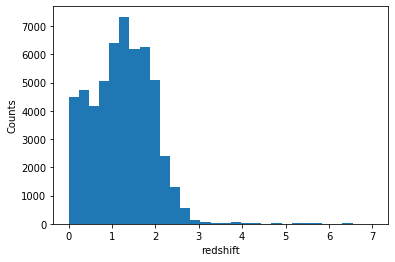

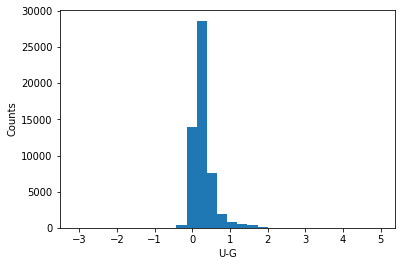

In [12]:
_ = plt.hist(output_raw[:,0],30)
plt.xlabel("redshift")
plt.ylabel("Counts")
plt.figure()
_ = plt.hist(input_raw[:,0],30)
plt.xlabel("U-G")
plt.ylabel("Counts")

In [13]:
scalerx = StandardScaler()
scalery = StandardScaler()

input_mod = scalerx.fit_transform(input_raw)
output_mod = scalery.fit_transform(output_raw)

### Train-test split

In [14]:
idx = np.arange(input_mod.shape[0])

#----------- Shuffle the indices
np.random.seed(2796)
np.random.shuffle(idx)
idx = list(idx)
#-----------------
trainlocs = idx[:int(len(idx) * 0.85)]
xtrain = input_mod[trainlocs,:]
ytrain = output_mod[trainlocs]
print(xtrain.shape,ytrain.shape)

#------------------
testlocs = idx[int(len(idx) * 0.85):]
xtest = input_mod[testlocs]
ytest = output_mod[testlocs]
print(xtest.shape,ytest.shape)

(46355, 4) (46355, 1)
(8181, 4) (8181, 1)


In [15]:
ytrain_og = scalery.inverse_transform(ytrain)
ytest_og = scalery.inverse_transform(ytest)

In [16]:
from sklearn.metrics import mean_absolute_percentage_error,r2_score,mean_squared_error
def Performance(target,prediction):
    print(f"Mean square error: {mean_squared_error(target,prediction)}")
    print(f"Mean absolute percentage error: {mean_absolute_percentage_error(target,prediction)}")
    print(f"R2 score: {r2_score(target,prediction)}")

In [17]:
def Make_scatter_plot(target,prediction):
    plt.figure()
    plt.scatter(target,prediction,s=2.0)
    plt.xlabel("Targets")
    plt.ylabel("predictions")

# First up, let us check how Linear regression works out

We will use $\color{#d08c60}{Scikit-learn}$ to perform linear regression. This assumes the form of our predictor as: 

$$z_{pred,j} = W_{ij}m_{i} + b_j,$$ where $m_{i}$ are the individual colors for each sample, and $j$ corresponds to each sample.



In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
LinReg = LinearRegression()
LinReg.fit(xtrain,ytrain)

LinearRegression()

In [20]:
ytrain_pred = LinReg.predict(xtrain)
ytest_pred = LinReg.predict(xtest)

In [21]:
ytrain_pred = scalery.inverse_transform(ytrain_pred)
ytest_pred = scalery.inverse_transform(ytest_pred)

In [22]:
print("Training set statistics")
Performance(ytrain_og,ytrain_pred)

Training set statistics
Mean square error: 0.4341474455449827
Mean absolute percentage error: 1.6382026041507045
R2 score: 0.11960032422078937


In [23]:
print("Testing set statistics")
Performance(ytest_og,ytest_pred)

Testing set statistics
Mean square error: 0.4130444409033818
Mean absolute percentage error: 2.8755175537844018
R2 score: 0.138727060676193


Text(0.5, 1.0, 'Testing set')

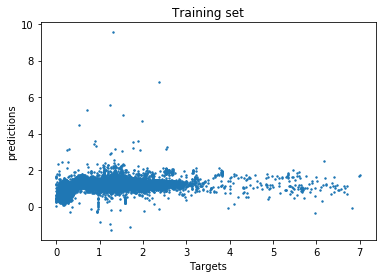

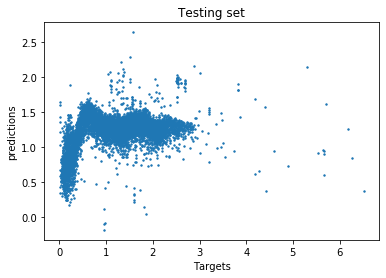

In [25]:
Make_scatter_plot(ytrain_og,ytrain_pred)
plt.title("Training set")
Make_scatter_plot(ytest_og,ytest_pred)
plt.title("Testing set")

That is fine performance for a linear model. But it could be better, so let's code up a neural network and check performance.

# Neural network

We shall use $\color{#dc2f02}{Pytorch}$ to make our neural network. You can use tensorflow or keras or whatever package you like -- pytorch is in vogue now, so we go ahead with it. 

## Pytorch structure

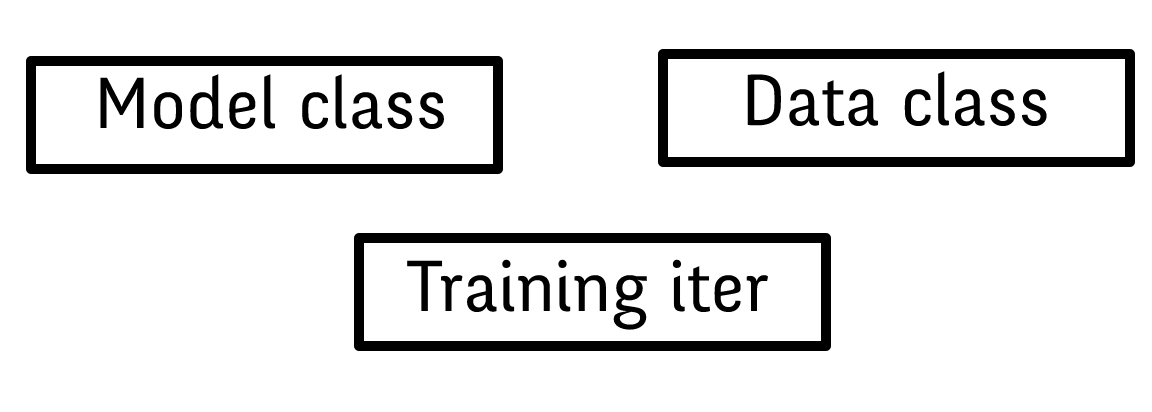

So basically, we need to write a small:
1. Data class, which will give us input and output for a given sample.
2. A model class which will define our network and generate output for a given input.
3. A *for* loop which will iterate over data and train the network.

In [18]:
import torch
import torch.nn as nn
from torch.utils import data

In [19]:
def _float(tensor):
    return torch.Tensor(tensor.astype(np.float32)).float()

In [20]:
class ReDNN(nn.Module):
    def __init__(self,nin,nout):
        super(ReDNN,self).__init__()
        self.NN = nn.Sequential(
                    nn.Linear(nin,12),
                    nn.ELU(inplace=True),
                    nn.Linear(12,26),
                    nn.ELU(inplace=True),
                    nn.Linear(26,14),
                    nn.ELU(inplace=True),
                    nn.Linear(14,7),
                    nn.ELU(inplace=True),
                    nn.Linear(7,nout)
        )
    def forward(self,input_data):
        return self.NN(input_data)

In [21]:
def MSE(true, pred):
    return ((true - pred)**2).mean().detach().cpu().numpy()

def Wrap_performance(true,pred):
    return Performance(true.detach().cpu().numpy(),pred.detach().cpu().numpy())

def loss_fn(true,pred):
    return ((true - pred)**2).mean()


In [22]:
torch.manual_seed(0)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [24]:
class Data(data.Dataset):
    def __init__(self,features,target):
        self.features = _float(features).to(device)
        self.target = _float(target).to(device)
        self.nout = target.shape[-1]
        self.nin = features.shape[-1]
    def __len__(self):
        return self.features.shape[0]
    def __getitem__(self,index):
        return self.features[index],self.target[index]

In [25]:
batch_size = 50000
lr = 1e-3
num_epochs = 10000

In [26]:
train_set = Data(xtrain,ytrain)
test_set = Data(xtest,ytest)

training_loader = data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
test_loader = data.DataLoader(test_set,batch_size=test_set.features.shape[0],shuffle=True)

In [27]:
#This defines our model
Redshift_model = ReDNN(train_set.nin,train_set.nout)
Redshift_model = Redshift_model.to(device).float()
print(Redshift_model)

ReDNN(
  (NN): Sequential(
    (0): Linear(in_features=4, out_features=12, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=12, out_features=26, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=26, out_features=14, bias=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): Linear(in_features=14, out_features=7, bias=True)
    (7): ELU(alpha=1.0, inplace=True)
    (8): Linear(in_features=7, out_features=1, bias=True)
  )
)


In [28]:
optimizer = torch.optim.Adam(Redshift_model.parameters(),lr=lr)

In [29]:
!nvidia-smi

/bin/sh: 1: nvidia-smi: not found


In [30]:
from tqdm import tqdm

In [31]:
training_stats = []
testing_stats = []
for i in tqdm(np.arange(num_epochs)):
    mse_loss = []
    for features,target in training_loader:
        optimizer.zero_grad()

        # features = features.to(device)
        # target = target.to(device)

        predictions = Redshift_model(features)

        loss = loss_fn(target, predictions)
        
        loss.backward()
        optimizer.step()

        mse_loss.append(loss.detach().cpu().numpy())
    training_stats.append(np.mean(mse_loss))
    with torch.no_grad():
        mse_loss = []
        for features,target in test_loader:
            # features = features.to(device)
            # target = target.to(device)

            predictions = Redshift_model(features)

            loss = loss_fn(target, predictions)
            mse_loss.append(loss.detach().cpu().numpy())
        
        testing_stats.append(np.mean(mse_loss))
    if i%100==0:
        print(f"Training loss: {training_stats[-1]}")
        print(f"Testing loss: {testing_stats[-1]}")

  0%|          | 1/10000 [00:00<1:09:08,  2.41it/s]

Training loss: 1.0429177284240723
Testing loss: 1.010424017906189


  1%|          | 101/10000 [00:35<1:00:22,  2.73it/s]

Training loss: 0.805014967918396
Testing loss: 0.7586883306503296


  2%|▏         | 201/10000 [01:11<56:39,  2.88it/s]  

Training loss: 0.5787550806999207
Testing loss: 0.5313055515289307


  3%|▎         | 301/10000 [01:47<57:07,  2.83it/s]  

Training loss: 0.5105524063110352
Testing loss: 0.47404029965400696


  4%|▍         | 401/10000 [02:22<55:19,  2.89it/s]  

Training loss: 0.47775566577911377
Testing loss: 0.44577157497406006


  5%|▌         | 501/10000 [02:58<59:30,  2.66it/s]  

Training loss: 0.4440903067588806
Testing loss: 0.4172672927379608


  6%|▌         | 601/10000 [03:34<53:21,  2.94it/s]  

Training loss: 0.42394933104515076
Testing loss: 0.3995254933834076


  7%|▋         | 701/10000 [04:10<57:42,  2.69it/s]  

Training loss: 0.4142536222934723
Testing loss: 0.3914772570133209


  8%|▊         | 801/10000 [04:45<53:29,  2.87it/s]  

Training loss: 0.40838703513145447
Testing loss: 0.3869340419769287


  9%|▉         | 901/10000 [05:21<52:20,  2.90it/s]

Training loss: 0.40470030903816223
Testing loss: 0.3835708796977997


 10%|█         | 1001/10000 [05:56<55:58,  2.68it/s] 

Training loss: 0.4009409248828888
Testing loss: 0.3813799321651459


 11%|█         | 1101/10000 [06:32<51:00,  2.91it/s]

Training loss: 0.39838942885398865
Testing loss: 0.3798573613166809


 12%|█▏        | 1201/10000 [07:07<50:24,  2.91it/s]

Training loss: 0.39623042941093445
Testing loss: 0.3786638379096985


 13%|█▎        | 1301/10000 [07:42<52:47,  2.75it/s]

Training loss: 0.3943498134613037
Testing loss: 0.37764668464660645


 14%|█▍        | 1401/10000 [08:18<50:57,  2.81it/s]

Training loss: 0.39277997612953186
Testing loss: 0.3767212927341461


 16%|█▌        | 1601/10000 [09:29<52:01,  2.69it/s]

Training loss: 0.3900764286518097
Testing loss: 0.3751850724220276


 17%|█▋        | 1701/10000 [10:05<48:16,  2.87it/s]

Training loss: 0.38888201117515564
Testing loss: 0.37455302476882935


 19%|█▉        | 1901/10000 [11:16<49:26,  2.73it/s]

Training loss: 0.38688868284225464
Testing loss: 0.37344351410865784


 20%|██        | 2001/10000 [11:52<45:43,  2.92it/s]

Training loss: 0.38601821660995483
Testing loss: 0.3729109764099121


 21%|██        | 2101/10000 [12:28<47:17,  2.78it/s]

Training loss: 0.38519349694252014
Testing loss: 0.3723355233669281


 22%|██▏       | 2201/10000 [13:04<45:29,  2.86it/s]

Training loss: 0.3844228684902191
Testing loss: 0.3718632757663727


 23%|██▎       | 2301/10000 [13:40<46:33,  2.76it/s]

Training loss: 0.38375142216682434
Testing loss: 0.3714633882045746


 24%|██▍       | 2401/10000 [14:15<46:11,  2.74it/s]

Training loss: 0.3831177055835724
Testing loss: 0.3710906505584717


 25%|██▌       | 2501/10000 [14:51<41:56,  2.98it/s]

Training loss: 0.3825947940349579
Testing loss: 0.3710826337337494


 26%|██▌       | 2601/10000 [15:26<44:14,  2.79it/s]

Training loss: 0.3819925785064697
Testing loss: 0.3704615533351898


 27%|██▋       | 2701/10000 [16:02<45:18,  2.69it/s]

Training loss: 0.38147443532943726
Testing loss: 0.3701893985271454


 28%|██▊       | 2801/10000 [16:38<40:21,  2.97it/s]

Training loss: 0.3809804618358612
Testing loss: 0.369965523481369


 29%|██▉       | 2901/10000 [17:13<42:49,  2.76it/s]

Training loss: 0.3805215060710907
Testing loss: 0.3697221577167511


 30%|███       | 3001/10000 [17:49<42:17,  2.76it/s]

Training loss: 0.38060641288757324
Testing loss: 0.37025347352027893


 31%|███       | 3101/10000 [18:24<40:13,  2.86it/s]

Training loss: 0.379647821187973
Testing loss: 0.3693101108074188


 32%|███▏      | 3201/10000 [19:00<39:50,  2.84it/s]

Training loss: 0.37922748923301697
Testing loss: 0.3691261112689972


 33%|███▎      | 3301/10000 [19:35<39:03,  2.86it/s]

Training loss: 0.37881237268447876
Testing loss: 0.3689388632774353


 34%|███▍      | 3401/10000 [20:11<39:03,  2.82it/s]

Training loss: 0.3783932328224182
Testing loss: 0.3688707947731018


 35%|███▌      | 3501/10000 [20:47<38:12,  2.83it/s]

Training loss: 0.3787841498851776
Testing loss: 0.36892756819725037


 36%|███▌      | 3601/10000 [21:22<38:32,  2.77it/s]

Training loss: 0.3776698708534241
Testing loss: 0.36871811747550964


 37%|███▋      | 3701/10000 [21:58<38:39,  2.72it/s]

Training loss: 0.3773338794708252
Testing loss: 0.3686498701572418


 38%|███▊      | 3801/10000 [22:33<39:49,  2.59it/s]

Training loss: 0.37703242897987366
Testing loss: 0.3685665428638458


 39%|███▉      | 3901/10000 [23:08<35:57,  2.83it/s]

Training loss: 0.37672001123428345
Testing loss: 0.3685436546802521


 40%|████      | 4001/10000 [23:44<34:13,  2.92it/s]

Training loss: 0.3766272962093353
Testing loss: 0.3687886893749237


 41%|████      | 4101/10000 [24:20<34:47,  2.83it/s]

Training loss: 0.37616315484046936
Testing loss: 0.368480384349823


 42%|████▏     | 4201/10000 [24:55<35:36,  2.71it/s]

Training loss: 0.3759009838104248
Testing loss: 0.36847397685050964


 43%|████▎     | 4301/10000 [25:31<35:46,  2.66it/s]

Training loss: 0.3756312429904938
Testing loss: 0.36847519874572754


 44%|████▍     | 4401/10000 [26:06<33:28,  2.79it/s]

Training loss: 0.37539058923721313
Testing loss: 0.3684680461883545


 45%|████▌     | 4501/10000 [26:41<31:50,  2.88it/s]

Training loss: 0.37514591217041016
Testing loss: 0.36847543716430664


 46%|████▌     | 4601/10000 [27:17<31:11,  2.89it/s]

Training loss: 0.3763253688812256
Testing loss: 0.3710669279098511


 47%|████▋     | 4701/10000 [27:52<32:28,  2.72it/s]

Training loss: 0.37463852763175964
Testing loss: 0.36849600076675415


 48%|████▊     | 4801/10000 [28:28<30:44,  2.82it/s]

Training loss: 0.37440380454063416
Testing loss: 0.3685078024864197


 49%|████▉     | 4901/10000 [29:03<30:42,  2.77it/s]

Training loss: 0.37427279353141785
Testing loss: 0.36858683824539185


 50%|█████     | 5001/10000 [29:38<29:00,  2.87it/s]

Training loss: 0.37396812438964844
Testing loss: 0.368507444858551


 51%|█████     | 5101/10000 [30:14<29:21,  2.78it/s]

Training loss: 0.37375494837760925
Testing loss: 0.36851006746292114


 52%|█████▏    | 5201/10000 [30:49<28:16,  2.83it/s]

Training loss: 0.37355926632881165
Testing loss: 0.36850547790527344


 53%|█████▎    | 5301/10000 [31:24<25:55,  3.02it/s]

Training loss: 0.373360812664032
Testing loss: 0.36851486563682556


 54%|█████▍    | 5401/10000 [32:00<26:31,  2.89it/s]

Training loss: 0.3740957975387573
Testing loss: 0.36875662207603455


 55%|█████▌    | 5501/10000 [32:35<26:15,  2.85it/s]

Training loss: 0.37297114729881287
Testing loss: 0.36849460005760193


 56%|█████▌    | 5601/10000 [33:11<27:27,  2.67it/s]

Training loss: 0.37277549505233765
Testing loss: 0.3685016334056854


 57%|█████▋    | 5701/10000 [33:46<24:58,  2.87it/s]

Training loss: 0.3725890815258026
Testing loss: 0.36846673488616943


 58%|█████▊    | 5801/10000 [34:22<24:32,  2.85it/s]

Training loss: 0.3724072277545929
Testing loss: 0.3684818148612976


 59%|█████▉    | 5901/10000 [34:58<25:18,  2.70it/s]

Training loss: 0.3722202479839325
Testing loss: 0.36849445104599


 60%|██████    | 6001/10000 [35:33<23:47,  2.80it/s]

Training loss: 0.3720431625843048
Testing loss: 0.3684445321559906


 61%|██████    | 6101/10000 [36:09<22:35,  2.88it/s]

Training loss: 0.3718603253364563
Testing loss: 0.3684447705745697


 62%|██████▏   | 6201/10000 [36:44<21:28,  2.95it/s]

Training loss: 0.37169891595840454
Testing loss: 0.3684428334236145


 63%|██████▎   | 6301/10000 [37:19<21:20,  2.89it/s]

Training loss: 0.37150198221206665
Testing loss: 0.3684423267841339


 64%|██████▍   | 6401/10000 [37:55<21:20,  2.81it/s]

Training loss: 0.3721151649951935
Testing loss: 0.3694412112236023


 65%|██████▌   | 6501/10000 [38:30<20:04,  2.90it/s]

Training loss: 0.37114617228507996
Testing loss: 0.36844587326049805


 66%|██████▌   | 6601/10000 [39:06<20:48,  2.72it/s]

Training loss: 0.37096482515335083
Testing loss: 0.36846739053726196


 67%|██████▋   | 6701/10000 [39:41<20:07,  2.73it/s]

Training loss: 0.37079960107803345
Testing loss: 0.3685048222541809


 68%|██████▊   | 6801/10000 [40:17<18:26,  2.89it/s]

Training loss: 0.37062007188796997
Testing loss: 0.36847764253616333


 69%|██████▉   | 6901/10000 [40:53<17:26,  2.96it/s]

Training loss: 0.3708796203136444
Testing loss: 0.3685731291770935


 70%|███████   | 7001/10000 [41:28<16:45,  2.98it/s]

Training loss: 0.37029075622558594
Testing loss: 0.3684837520122528


 71%|███████   | 7101/10000 [42:04<17:50,  2.71it/s]

Training loss: 0.37012389302253723
Testing loss: 0.3685140311717987


 72%|███████▏  | 7201/10000 [42:39<17:05,  2.73it/s]

Training loss: 0.3700970411300659
Testing loss: 0.36936911940574646


 73%|███████▎  | 7301/10000 [43:15<16:49,  2.67it/s]

Training loss: 0.36979568004608154
Testing loss: 0.3685391843318939


 74%|███████▍  | 7401/10000 [43:50<15:45,  2.75it/s]

Training loss: 0.36962783336639404
Testing loss: 0.36857864260673523


 75%|███████▌  | 7501/10000 [44:25<14:44,  2.82it/s]

Training loss: 0.36946842074394226
Testing loss: 0.36856886744499207


 76%|███████▌  | 7601/10000 [45:01<13:22,  2.99it/s]

Training loss: 0.36928999423980713
Testing loss: 0.3686386048793793


 77%|███████▋  | 7701/10000 [45:36<14:11,  2.70it/s]

Training loss: 0.36912277340888977
Testing loss: 0.3687869906425476


 78%|███████▊  | 7801/10000 [46:12<13:13,  2.77it/s]

Training loss: 0.3689476549625397
Testing loss: 0.36871597170829773


 79%|███████▉  | 7901/10000 [46:47<12:41,  2.76it/s]

Training loss: 0.3687781095504761
Testing loss: 0.36879971623420715


 80%|████████  | 8001/10000 [47:23<12:06,  2.75it/s]

Training loss: 0.3685983121395111
Testing loss: 0.3688943684101105


 81%|████████  | 8101/10000 [47:59<11:54,  2.66it/s]

Training loss: 0.36843061447143555
Testing loss: 0.3689413070678711


 82%|████████▏ | 8201/10000 [48:34<10:24,  2.88it/s]

Training loss: 0.3682593107223511
Testing loss: 0.36903420090675354


 83%|████████▎ | 8301/10000 [49:10<10:20,  2.74it/s]

Training loss: 0.3681250810623169
Testing loss: 0.36903655529022217


 84%|████████▍ | 8401/10000 [49:45<09:50,  2.71it/s]

Training loss: 0.3679257333278656
Testing loss: 0.36918210983276367


 85%|████████▌ | 8501/10000 [50:21<08:34,  2.91it/s]

Training loss: 0.3685164153575897
Testing loss: 0.37005478143692017


 86%|████████▌ | 8601/10000 [50:56<08:33,  2.73it/s]

Training loss: 0.3675999045372009
Testing loss: 0.36931735277175903


 87%|████████▋ | 8701/10000 [51:32<07:57,  2.72it/s]

Training loss: 0.3674386143684387
Testing loss: 0.36938953399658203


 88%|████████▊ | 8801/10000 [52:08<06:58,  2.87it/s]

Training loss: 0.36773666739463806
Testing loss: 0.3706035017967224


 89%|████████▉ | 8901/10000 [52:43<06:21,  2.88it/s]

Training loss: 0.36712881922721863
Testing loss: 0.36951300501823425


 90%|█████████ | 9001/10000 [53:19<05:54,  2.82it/s]

Training loss: 0.36697572469711304
Testing loss: 0.36958932876586914


 91%|█████████ | 9101/10000 [53:54<05:26,  2.76it/s]

Training loss: 0.36685261130332947
Testing loss: 0.36975985765457153


 92%|█████████▏| 9201/10000 [54:29<05:00,  2.66it/s]

Training loss: 0.3666819632053375
Testing loss: 0.36970487236976624


 93%|█████████▎| 9301/10000 [55:05<04:04,  2.86it/s]

Training loss: 0.3665861487388611
Testing loss: 0.36973869800567627


 94%|█████████▍| 9401/10000 [55:40<03:23,  2.94it/s]

Training loss: 0.3664065897464752
Testing loss: 0.36981743574142456


 95%|█████████▌| 9501/10000 [56:16<02:47,  2.97it/s]

Training loss: 0.3662739396095276
Testing loss: 0.3698887825012207


 96%|█████████▌| 9601/10000 [56:51<02:20,  2.84it/s]

Training loss: 0.3661373555660248
Testing loss: 0.36996743083000183


 97%|█████████▋| 9701/10000 [57:27<01:47,  2.78it/s]

Training loss: 0.36601170897483826
Testing loss: 0.3699497580528259


 98%|█████████▊| 9801/10000 [58:02<01:11,  2.77it/s]

Training loss: 0.36588054895401
Testing loss: 0.3700923025608063


 99%|█████████▉| 9901/10000 [58:38<00:35,  2.81it/s]

Training loss: 0.36575615406036377
Testing loss: 0.3704265058040619


100%|██████████| 10000/10000 [59:13<00:00,  2.81it/s]


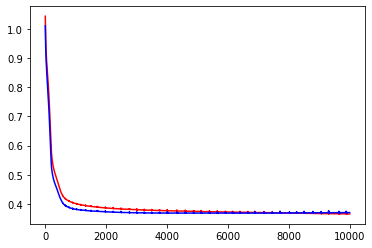

In [32]:
plt.plot(training_stats,'r')
plt.plot(testing_stats,'b')

In [33]:
xtmp,ytrain_scaled = train_set[:]
ytrain_scaled = ytrain_scaled.detach().cpu().numpy()
ytrain_pred = Redshift_model(xtmp.to(device)).detach().cpu().numpy()

xtmp,ytest_scaled = test_set[:]
ytest_scaled = ytest_scaled.detach().cpu().numpy()
ytest_pred = Redshift_model(xtmp.to(device)).detach().cpu().numpy()

In [34]:
ytrain_pred = scalery.inverse_transform(ytrain_pred)
ytest_pred = scalery.inverse_transform(ytest_pred)

ytrain_unscaled = scalery.inverse_transform(ytrain_scaled)
ytest_unscaled = scalery.inverse_transform(ytest_scaled)

In [35]:
print("Training set statistics")
Performance(ytrain_unscaled,ytrain_pred)

Training set statistics
Mean square error: 0.17955991625785828
Mean absolute percentage error: 1.4118765592575073
R2 score: 0.6358737369203818


In [36]:
print("Testing set statistics")
Performance(ytest_unscaled,ytest_pred)

Testing set statistics
Mean square error: 0.18180879950523376
Mean absolute percentage error: 3.0428426265716553
R2 score: 0.6208955050640239


Text(0.5, 1.0, 'Testing set')

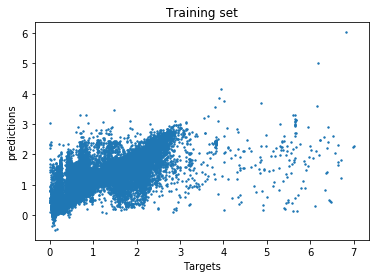

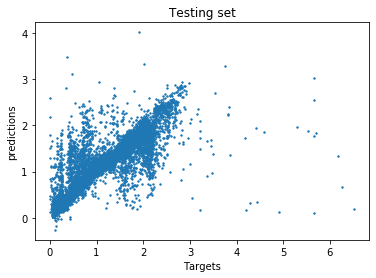

In [37]:
Make_scatter_plot(ytrain_unscaled,ytrain_pred)
plt.title("Training set")
Make_scatter_plot(ytest_unscaled,ytest_pred)
plt.title("Testing set")